In [1]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(ComplexHeatmap)
library(circlize)

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: grid

ComplexHeatmap version 2.2.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.


circlize version 0.4.13
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and

In [2]:
exn <- readRDS(file = paste0("./load_files/", "ExN_plusbgcells_raw.rds")) 

file_name <- "ExN_shmars"
sel_cls <- c("IPC EOMES VIM", "IPC_EOMES_NEUROG1", "IPC_EOMES_NHLH1_deep", "IPC_EOMES_NHLH1_up", 
            "ExN_deep_nascent", "ExN_deep_KIF26A", "ExN_deep_NR4A2_GRID2", "ExN_deep_SYT6", 
             "ExN_deep_OPRK1_NR4A2", "ExN_deep_OPRK1_SULF1", 
            "ExN_up_nascent", "ExN_up_KCNV1", "ExN_up_ADRA2A", "ExN_up_ACTN2")
exn <- exn[, exn@meta.data$subtype %in% sel_cls]

In [3]:
marFile <- paste0("./load_files/", "Share_mars_ExN_all.rds")
if (!file.exists(marFile)){
    cls_regs <- list(`ExN_deep_KIF26A` = c("FC", "MSC", "OcC", "TC"), 
                `ExN_deep_nascent` = c("FC", "MSC", "OcC", "TC"), 
                `ExN_deep_NR4A2_GRID2` = c("FC", "MSC", "OcC", "TC"), 
                `ExN_deep_OPRK1_NR4A2` = c("FC", "MSC", "TC"),
                `ExN_deep_OPRK1_SULF1` = c("FC"),
                `ExN_deep_SYT6` = c("FC", "MSC", "OcC", "TC"), 
                `ExN_up_ACTN2` = c("FC", "MSC", "OcC", "TC"), 
                `ExN_up_ADRA2A` = c("FC", "MSC", "OcC", "TC"), 
                `ExN_up_KCNV1` = c("FC", "TC"), 
                `ExN_up_nascent` = c("FC", "MSC", "OcC", "TC"), 
                `IPC EOMES VIM` = c("FC", "MSC", "OcC", "TC"),
                `IPC_EOMES_NEUROG1` = c("FC", "MSC", "OcC", "TC"),
                `IPC_EOMES_NHLH1_deep` = c("FC", "MSC", "OcC", "TC"),
                `IPC_EOMES_NHLH1_up` = c("FC", "MSC", "OcC", "TC"))

    reg_list <- SplitObject(exn, split.by = "lobe")
    for (ii in names(reg_list)){
            Idents(reg_list[[ii]]) <- "subtype"
    }

    ## Calculate shared markers
    shmars <- lapply(names(cls_regs), function(cls){
        cur_regs <- cls_regs[[cls]]
        allres <- lapply(cur_regs, function(reg) {
            xx <- reg_list[[reg]]
            res <- FindMarkers(xx, ident.1 = cls, only.pos = TRUE, 
                               max.cells.per.ident = 1000, min.pct = 0.1, logfc.threshold = 0.25) %>%
                    rownames_to_column("gene") %>%
                    mutate(ratio_fc = (pct.1 + 0.01)/(pct.2 + 0.01)) %>%
                    mutate(region = reg)
            res
            }) %>%
                do.call(rbind, .)

        message(paste0("Finding markers for cluster: ", cls))
        mars <- allres %>%
                    filter(ratio_fc >= 1.1 & p_val_adj <= 0.01) %>%
                    group_by(gene) %>%
                    summarize(nhits = n(), mfc = mean(ratio_fc)) %>%
                    ungroup() %>%
                    filter(nhits >= ceiling(length(cur_regs) * 0.5)) %>%
                    mutate(cluster = cls) %>%
                    arrange(desc(nhits), desc(mfc))

        if (nrow(mars) > 200){
            genes <- mars$gene[1:200]
        } else {
            genes <- mars$gene
        }
        genes
        }) %>%
            setNames(., names(cls_regs))

    saveRDS(shmars, file = marFile)
}
shmars <- readRDS(file = marFile)


In [4]:
## Set the data for visualization
set.seed(0)
sel_regs <- c("FC", "MSC", "OcC", "TC")
## balanced number of cells from each region
cells <- lapply(sel_cls, function(cls) {
    regcells <- lapply(sel_regs, function(reg) {
        subc <- colnames(exn)[exn@meta.data$subtype == cls & exn@meta.data$lobe == reg]
        if (length(subc) <= 50){
            subc <- c()
        } else if (length(subc) > 50 & length(subc) <= 100){
            subc <- subc
        } else {
            subc <- sample(subc, 100)
        }
        return(subc)
        }) %>%
            unlist() %>% unique()
    regcells
    }) %>%
        unlist() %>% unique()
vis_exn <- exn[, cells]


pgenes <- lapply(sel_cls, function(x) shmars[[x]][1:min(length(shmars[[x]]), 100)]) %>% unlist() %>% unique()
mat <- vis_exn$RNA@data[pgenes, ,drop = FALSE] %>%
        as.matrix() %>%
        t() %>% scale() %>% t() %>%
        MinMax(., min = -1.5, max = 2.5)

In [5]:
cls_cols <- setNames(c("#ed5d09", "#bf812d", 
                       "#b35806","#f56122",
                        "#91ebe2", "#48a1e0", "#0868ac", "#4eb3d3", 
                       "#c6dbef", "#a5b8c9", 
                "#e89bc4", "#D3D3D3", "#de77ae", "#c51b7d"), 
            c("IPC EOMES VIM", "IPC_EOMES_NEUROG1", 
              "IPC_EOMES_NHLH1_deep","IPC_EOMES_NHLH1_up",
            "ExN_deep_nascent","ExN_deep_KIF26A","ExN_deep_SYT6", "ExN_deep_NR4A2_GRID2",
              "ExN_deep_OPRK1_NR4A2","ExN_deep_OPRK1_SULF1",
                "ExN_up_nascent","ExN_up_KCNV1", "ExN_up_ADRA2A","ExN_up_ACTN2"))
reg_cols <- c("#FF420E", "#FFBB00", "#4CB5F5", "#89DA59", "#878787", "#B037C4") %>% 
                setNames(., c("FC", "MSC", "TC", "OcC", "Insula", "GE")) %>% 
                .[1:4]

 [1] "LOC114678346" "ZSWIM6"       "ABI3BP"       "MCM3"         "XKR4"        
 [6] "SYN3"         "ADAMTSL1"     "CDK2AP1"      "RPL35"        "CENPT"       
[11] "HES6"         "BDNF"         "LOC697476"    "ACSL4"        "NCS1"        
[16] "PLXDC2"       "CAMK2N1"      "NENF"         "GPR85"        "SLC24A4"     
[21] "TRH"          "ASCL1"        "BIRC5"        "SNTG1"        "LOC106994345"
[26] "NECAB1"       "SULF1"        "FAM127A"      "EML1"         "RPL38"       
[31] "GRP"          "NEO1"         "WRB"          "SPTAN1"       "CAMK4"       
[36] "HTRA1"        "GPRIN1"       "GRM3"         "ATP5MG"       "CDK1"        
[41] "VIM"          "PAX6"         "EOMES"        "NEUROG1"      "GADD45G"     
[46] "PPP1R17"      "ASCL1"        "NHLH1"        "NEUROD4"      "PALMD"       
[51] "CUX2"         "SATB2"        "SOX5"         "TLE4"         "OPRK1"       
[56] "SYT6"         "NR4A2"        "ADRA2A"       "ACTN2"        "ST18"        


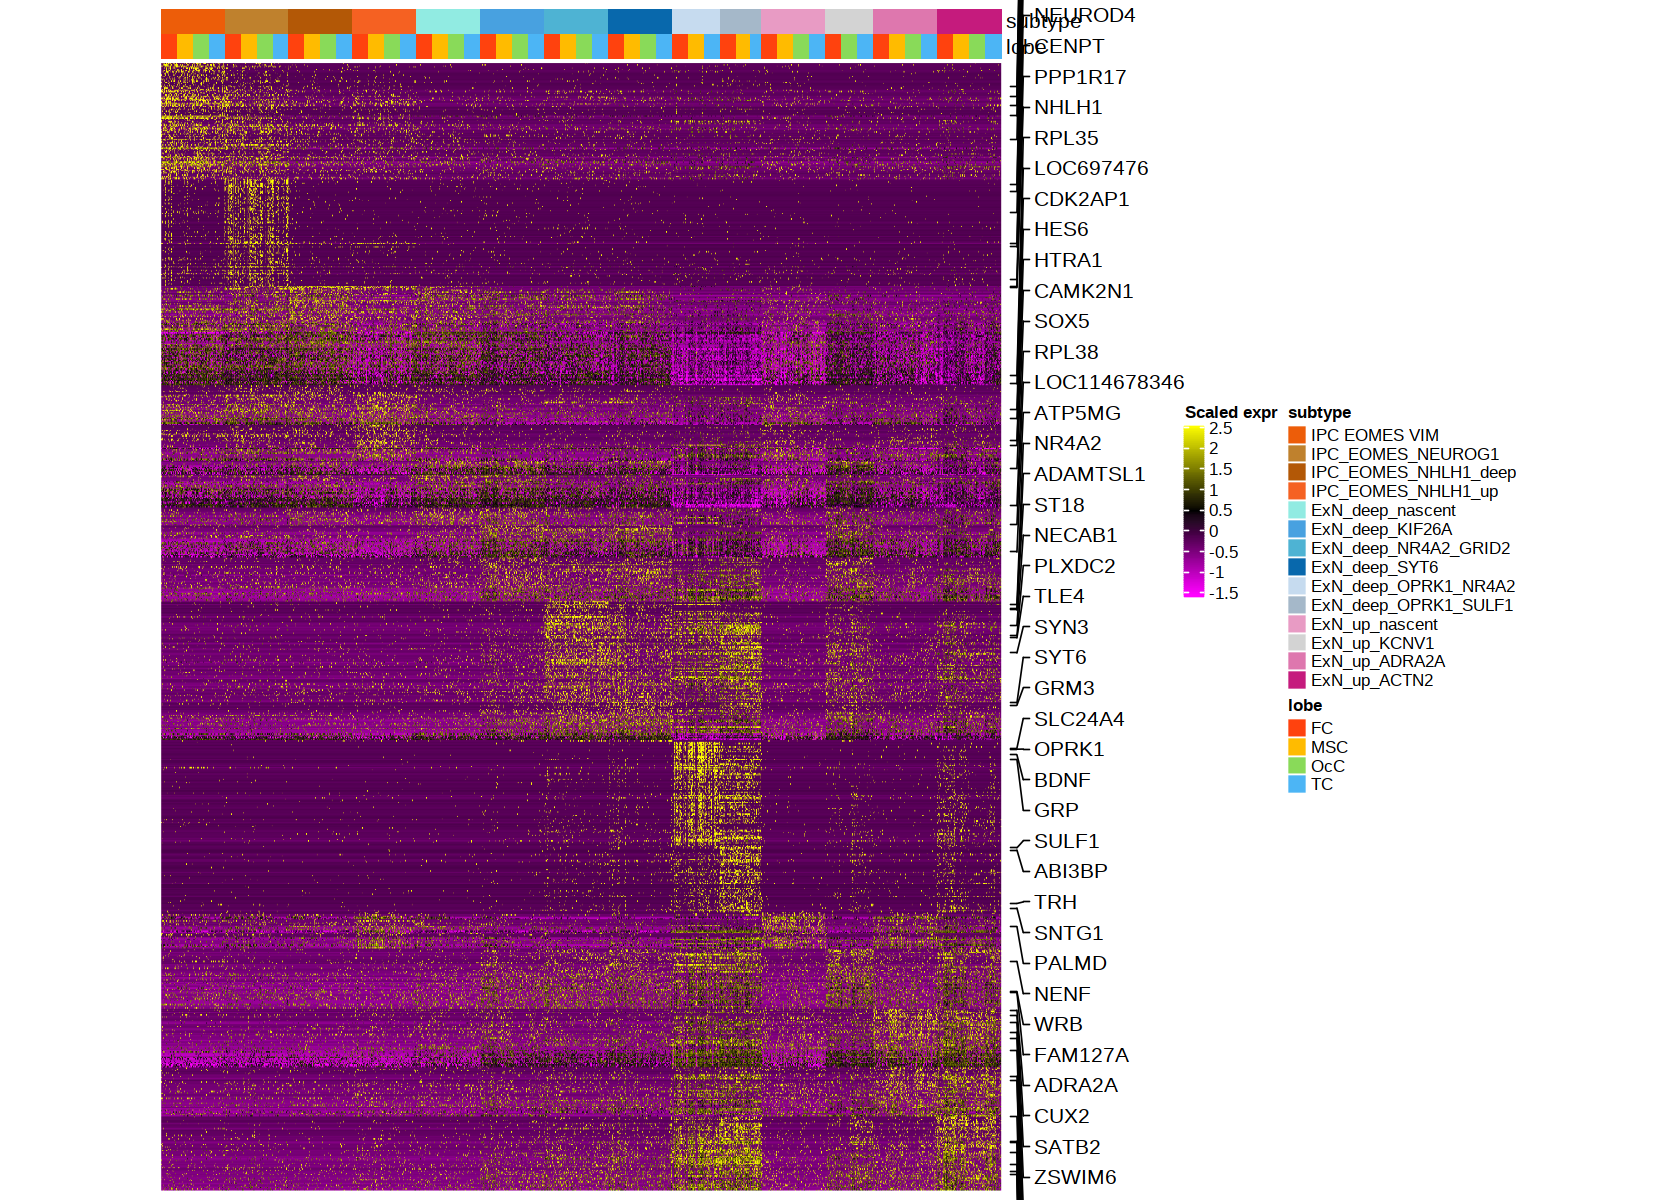

In [10]:
#row_split = factor(extract_field(rownames(mat), 1, "|"), levels = sel_cls),   
fun1 <- colorRampPalette(c("#FF00FF", "black", "#FFFF00"))
color_breaks <- c(-1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5)
col_fun = circlize::colorRamp2(color_breaks, fun1(9))
pmeta <- vis_exn@meta.data[, c("subtype", "lobe")]
pmeta$subtype <- factor(pmeta$subtype, levels = sel_cls)
pmeta$lobe <- factor(pmeta$lobe, levels = c("FC", "MSC", "OcC", "TC"))

column_ha <- HeatmapAnnotation(df = pmeta, col = list(lobe = reg_cols, subtype = cls_cols), 
                               annotation_height = unit(c(0.01, 0.01), "in"))
htlist <- Heatmap(mat, name = "Expression", 
        col = col_fun, na_col = "#FF00FF",
        cluster_rows = FALSE, cluster_columns = FALSE, 
        row_title_rot = 90, column_title = NULL, row_title_gp = gpar(fontsize = 12), 
        show_column_names = FALSE, show_row_names = FALSE, 
                  column_names_gp = gpar(fontsize = 10),
                  column_names_rot = 45, 
        width = unit(7, "in"),
        top_annotation = column_ha, 
        heatmap_legend_param = list(title = "Scaled expr", color_bar = "continuous", at = color_breaks),
        use_raster = TRUE, raster_quality = 3)



set.seed(0)
label_genes <- sample(rownames(mat), 40) %>%
                c(., c("VIM", "PAX6", "EOMES", "NEUROG1", "GADD45G", "PPP1R17", "ASCL1", "NHLH1", 
                       "NEUROD4", "PALMD", "CUX2", "SATB2", "SOX5", "TLE4", "OPRK1", 
                       "SYT6", "NR4A2", "ADRA2A", "ACTN2", "ST18"))
print(label_genes)
htlist <- htlist + 
            HeatmapAnnotation(link = anno_mark(at = which(rownames(mat) %in% label_genes), 
                                    labels = rownames(mat)[which(rownames(mat) %in% label_genes)], 
                                    side = "right",
                                    labels_gp = gpar(fontsize = 12), padding = unit(1, "mm")),
                                which = "row",
                                name = "aaa")
options(repr.plot.width=14, repr.plot.height=10)
draw(htlist)

In [11]:
pdf(paste0("./report/", "ExN_markers_heatmap.pdf"), width = 14, height = 10)
draw(htlist)
dev.off()

png 
  2

In [8]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS/LAPACK: /gpfs/gibbs/pi/sestan.ycga/sm2726/Tools/Anaconda3/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] circlize_0.4.13      ComplexHeatmap_2.2.0 ggplot2_3.3.0       
[4] dplyr_1.0.7          Seurat_3.1.5        

loaded via a namespace (and not attached):
 [1] nlme_3.1-147        tsne_0.1-3          RcppAnnoy_0.0.16   
 [4] RColorBrewer_1.1-2  